In [1]:

import project_utils as u
import os
import matplotlib.pyplot as plt
import pandas as pd

COST_REPORT_PATH = './data/cost_report/'

TAX_YEAR = 2022
MIN_HOSPITAL_REV = 250_000_000
MAX_HOSPITAL_REV = 500_000_000
CMS_YEAR = 2022
CMS_DATASET_ID = f"hospitals_10_2022"
CMS_URL = f'https://data.cms.gov/provider-data/sites/default/files/archive/Hospitals/{CMS_YEAR}/{CMS_DATASET_ID}.zip'
CMS_ZIP_PATH = f"./load/hospitals/"
CMS_EXTRACT_PATH = f"data/hospitals/"

INCENTIVE_PERC_LIMIT = None # 1000000000000

cms_root_path = u.get_cms_data(CMS_URL, CMS_ZIP_PATH, CMS_EXTRACT_PATH, CMS_DATASET_ID)


columns = {
    'Facility ID - HCAHPS': 'Facility ID',
    'Facility Name - HCAHPS': 'Facility Name',
    'Region Unencoded': 'Region',
    'health_sys_id': 'health_sys_id',
    'health_system_size': 'health_system_size',
    'ein - 990': "EIN",
    'is_teaching_hospital - cost report': 'is_teaching_hospital',
    'incentive_perc - 990': 'incentive_perc',
    'Number of Beds - cost report': 'Number of Beds',
    'op_margin - 990': 'Operating Margin',

    'Overall hospital rating - linear mean score: HCAHPS Linear Mean Value - HCAHPS': 'Overall Linear Mean HCAHPS Hospital Rating',
    "Death rate for CABG surgery patients: Score - complications and mortality report": "CABG Death Rate Score",
    "Death rate for COPD patients: Score - complications and mortality report": "COPD Death Rate Score",
    "Death rate for heart attack patients: Score - complications and mortality report": "Heart Attack Death Rate Score",
    "Death rate for heart failure patients: Score - complications and mortality report": "Heart Failure Death Rate Score",
    "Death rate for stroke patients: Score - complications and mortality report": "Stroke Death Rate Score",
    "Rate of complications for hip/knee replacement patients: Score - complications and mortality report": "Rate of Complications of Hip or Knee Replacement Score",
    
    
}

bins = [0, 1, 2, 3, 4, 5]
merged = u.join_datasets(TAX_YEAR, 
                       MIN_HOSPITAL_REV,
                       MAX_HOSPITAL_REV,
                       cms_root_path,
                       COST_REPORT_PATH,
                       columns = columns,
                       incentive_perc_limit = INCENTIVE_PERC_LIMIT,
                       opts = {
                           'region_pivot': 'Region',
                           'healthcare_system_pivot': True,
                           'healthcare_system_bins': bins
                       })

print("num records = ", len(merged))

./load/hospitals/hospitals_10_2022.zip already exists. Skipping download
unzipping ./load/hospitals/hospitals_10_2022.zip to data/hospitals/...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 50.74it/s]


{'region_pivot': 'Region', 'healthcare_system_pivot': True, 'healthcare_system_bins': [0, 1, 2, 3, 4, 5]}


/workspace/project_utils.py:408: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  hcahps = pd.read_csv(os.path.join(cms_root_path, 'HCAHPS-Hospital.csv'))


num records =  84


{'num_samples': 38, 'x': 'incentive_perc', 'y': 'Overall Linear Mean HCAHPS Hospital Rating', 'slope': np.float64(-6.859418749987821), 'intercept': np.float64(89.59586320264215), 'p': np.float64(0.34542835767981184), 'std_err': np.float64(7.174823215607839)}
not enough samples for incentive_perc vs CABG Death Rate Score
{'num_samples': 35, 'x': 'incentive_perc', 'y': 'COPD Death Rate Score', 'slope': np.float64(0.7652846392727676), 'intercept': np.float64(8.637479707248913), 'p': np.float64(0.5867325398078865), 'std_err': np.float64(1.394077966923334)}
not enough samples for incentive_perc vs Heart Attack Death Rate Score
{'num_samples': 44, 'x': 'incentive_perc', 'y': 'Heart Failure Death Rate Score', 'slope': np.float64(-0.1351904510112443), 'intercept': np.float64(12.155829221843522), 'p': np.float64(0.9542735839163083), 'std_err': np.float64(2.3436219011722983)}
{'num_samples': 7, 'x': 'incentive_perc', 'y': 'Stroke Death Rate Score', 'slope': np.float64(-4.046003508882263), 'inter

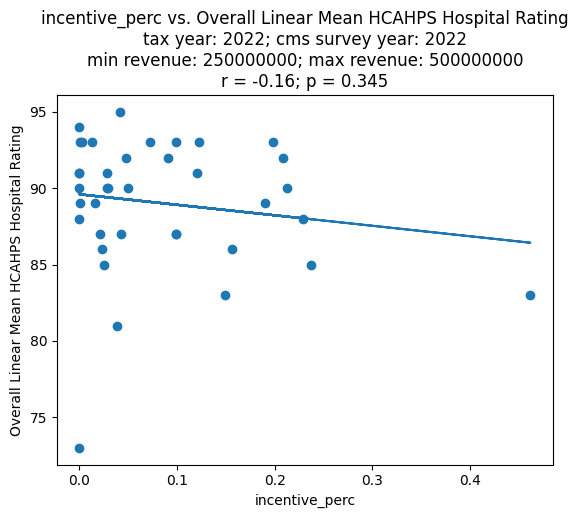

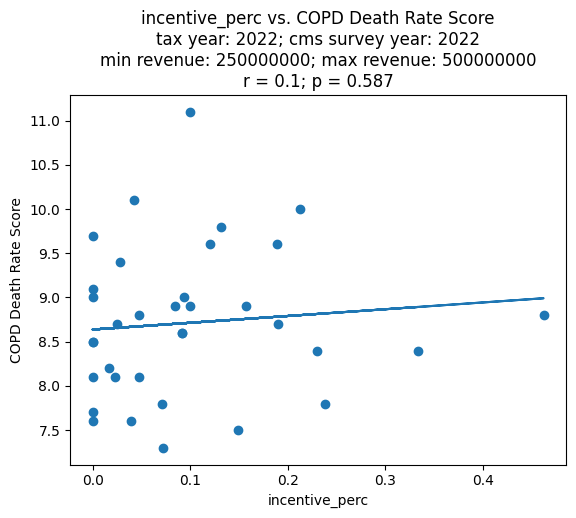

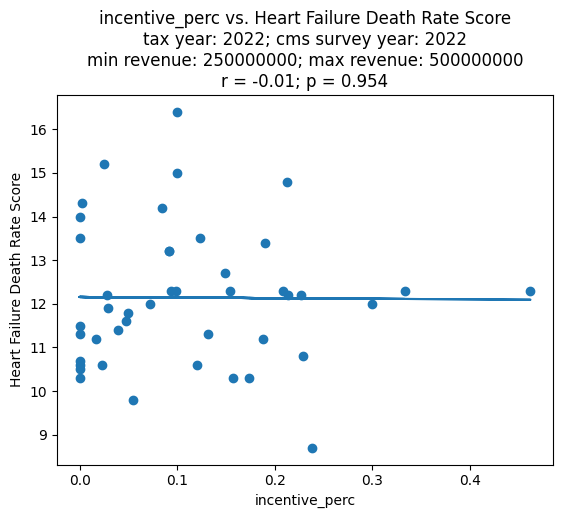

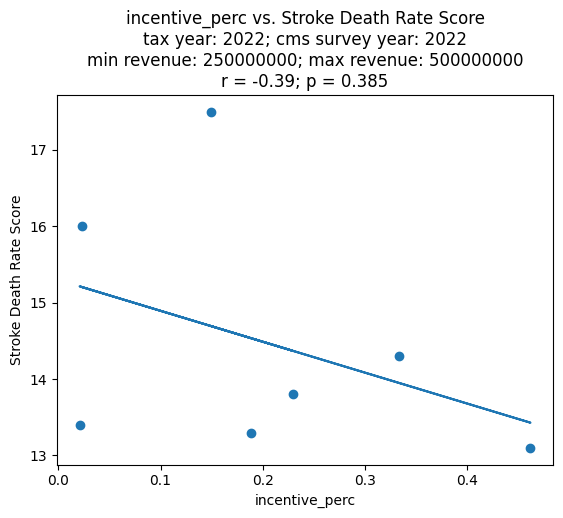

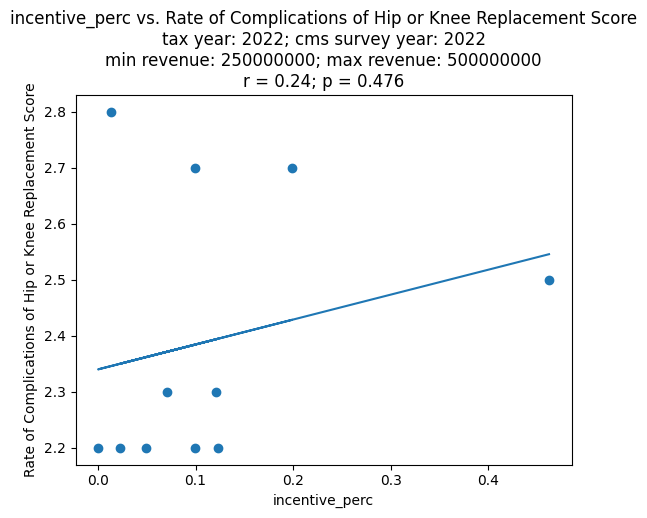

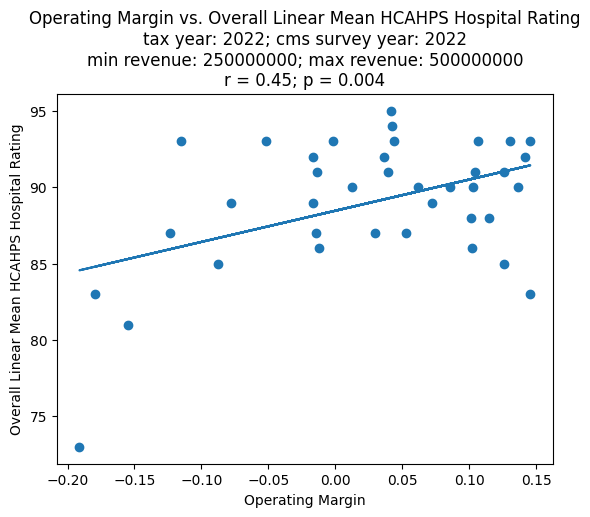

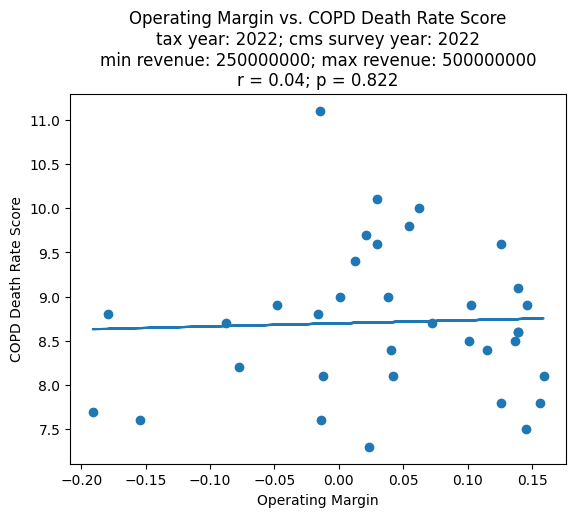

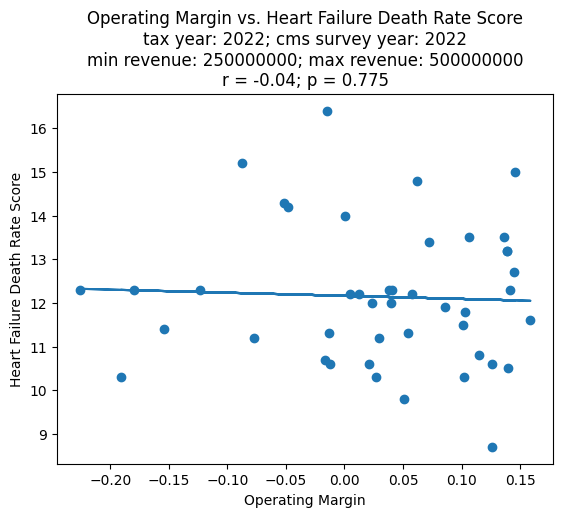

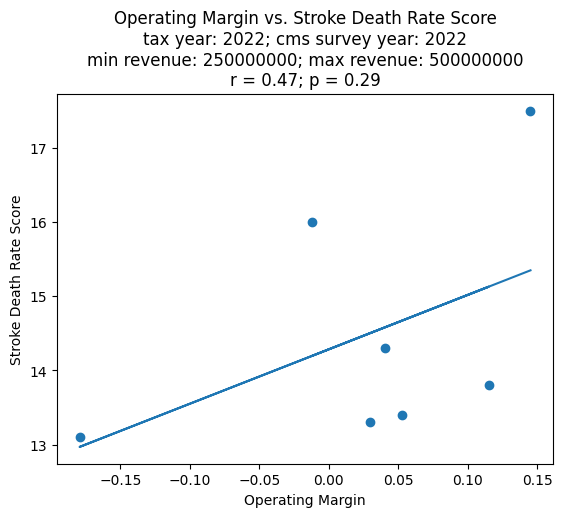

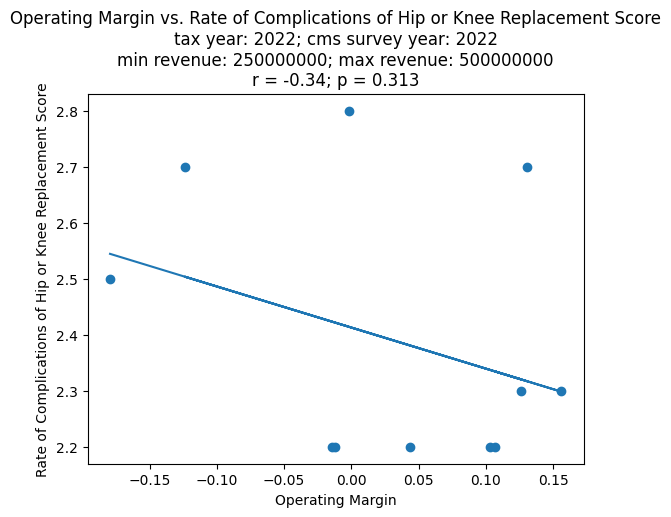

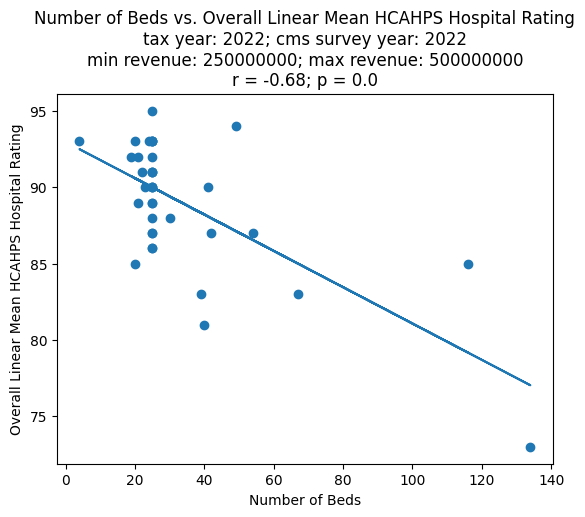

In [7]:

from scipy import stats
def plot_results(x_col,
                 y_col,
                 merged,
                 year,
                 min_rev,
                 max_rev):

    merged = merged[[x_col, y_col]].dropna()

    if len(merged) < 5:
        print(f"not enough samples for {x_col} vs {y_col}")
        return []
        
    x = merged[x_col]
    y = merged[y_col]

    fig_id = f"{x_col}_vs_{y_col}_year={year}_cmsYear={2022}_minRev={min_rev}_maxRev={max_rev}"
    
    m, b, r, p, std_err = stats.linregress(x, y)

    fig = plt.subplots()
    
    plt.scatter(x, y)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'{x_col} vs. {y_col}\n' +\
              f'tax year: {year}; cms survey year: 2022\n' +\
              f'min revenue: {min_rev}; max revenue: {max_rev}\n' +\
              f"r = {round(r, 2)}; p = {round(p, 3)}")
    plt.plot(x, list(map(lambda x: (m * x) + b, x)))
    results = {
        'num_samples': len(merged),
        'x': x_col,
        'y': y_col,
        'slope': m,
        'intercept': b,
        'p': p,
        'std_err': std_err,
    }

    print(results)
    plt.savefig(f"results/{fig_id}.png")

    return results

recs = []
for dep_var in [
    'Overall Linear Mean HCAHPS Hospital Rating',
    'CABG Death Rate Score',
    'COPD Death Rate Score',
    'Heart Attack Death Rate Score',
    'Heart Failure Death Rate Score',
    'Stroke Death Rate Score',
    'Rate of Complications of Hip or Knee Replacement Score'
]:
    r = plot_results('incentive_perc', dep_var, merged, TAX_YEAR, MIN_HOSPITAL_REV, MAX_HOSPITAL_REV)
    if len(r) > 0:
        recs.append(r)
recs = pd.DataFrame(recs)
recs.to_csv(f"results/linreg_results_x=incentive_perc_year={TAX_YEAR}.csv")


recs = []
for dep_var in [
    'Overall Linear Mean HCAHPS Hospital Rating',
    'CABG Death Rate Score',
    'COPD Death Rate Score',
    'Heart Attack Death Rate Score',
    'Heart Failure Death Rate Score',
    'Stroke Death Rate Score',
    'Rate of Complications of Hip or Knee Replacement Score'
]:
    r = plot_results('Operating Margin', dep_var, merged, TAX_YEAR, MIN_HOSPITAL_REV, MAX_HOSPITAL_REV)
    if len(r) > 0:
        recs.append(r)

recs.append(plot_results('Number of Beds', 'Overall Linear Mean HCAHPS Hospital Rating', merged, TAX_YEAR, MIN_HOSPITAL_REV, MAX_HOSPITAL_REV))
recs = pd.DataFrame(recs)
recs.to_csv(f"results/linreg_results_x=operating_margin_year={TAX_YEAR}.csv")

In [3]:

import statsmodels.api as sm

df_model = merged[['is_teaching_hospital',
                   'Number of Beds',
                   'incentive_perc',
                   'Region_Northeast',
                   'Region_Region Not Found',
                   'Region_South',
                   'Region_West',
                   'health_system_size',
                   'Operating Margin',
                   'Overall Linear Mean HCAHPS Hospital Rating']].dropna()
X = df_model[[
    'is_teaching_hospital',
    'Number of Beds',
    'incentive_perc',
    'Region_Northeast',
    'Region_Region Not Found',
    'Region_South',
    'Region_West',
    'Operating Margin',
    'health_system_size',
]]
X = sm.add_constant(X)

Y = df_model['Overall Linear Mean HCAHPS Hospital Rating']

model = sm.OLS(Y, X)
results = model.fit()

with open(f"results/ols_y=mean_hcahps_hospital_rating_year={TAX_YEAR}_cmsYear={2022}_minRev={MIN_HOSPITAL_REV}_maxRev={MAX_HOSPITAL_REV}.txt", "w") as f:
    f.write(results.summary().as_text())
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        OLS Regression Results                                        
======================================================================================================
Dep. Variable:     Overall Linear Mean HCAHPS Hospital Rating   R-squared:                       0.629
Model:                                                    OLS   Adj. R-squared:                  0.527
Method:                                         Least Squares   F-statistic:                     6.145
Date:                                        Sun, 05 Oct 2025   Prob (F-statistic):           0.000119
Time:                                                23:37:10   Log-Likelihood:                -89.914
No. Observations:                                          38   AIC:                             197.8
Df Residuals:                                              29   BIC:                             212.6
Df Model:                                                   8                                         
Covariance Type:                                    nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      94.3371      1.337     70.536      0.000      91.602      97.072
is_teaching_hospital        7.6453      4.110      1.860      0.073      -0.760      16.051
Number of Beds             -0.1342      0.028     -4.800      0.000      -0.191      -0.077
incentive_perc             -5.0194      5.519     -0.910      0.371     -16.306       6.268
Region_Northeast           -1.7061      1.511     -1.129      0.268      -4.796       1.383
Region_Region Not Found  2.491e-14   1.46e-14      1.712      0.098   -4.85e-15    5.47e-14
Region_South               -0.0454      1.225     -0.037      0.971      -2.552       2.461
Region_West                -2.7088      1.814     -1.494      0.146      -6.418       1.001
Operating Margin           13.5725      6.429      2.111      0.043       0.424      26.720
health_system_size         -0.0430      0.030     -1.447      0.159      -0.104       0.018
==============================================================================
Omnibus:                        2.467   Durbin-Watson:                   2.211
Prob(Omnibus):                  0.291   Jarque-Bera (JB):                1.709
Skew:                          -0.515   Prob(JB):                        0.425
Kurtosis:                       3.129   Cond. No.                     5.69e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.13e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [4]:

df_model = merged[['is_teaching_hospital',
                   'Number of Beds',
                   'incentive_perc',
                   'Region_Northeast',
                   'Region_Region Not Found',
                   'Region_South',
                   'Region_West',
                   'health_system_size',
                   'Operating Margin',
                   'Heart Failure Death Rate Score']].dropna()
X = df_model[[
    'is_teaching_hospital',
    'Number of Beds',
    'incentive_perc',
    'Region_Northeast',
    'Region_Region Not Found',
    'Region_South',
    'Region_West',
    'Operating Margin',
    'health_system_size',
]]
X = sm.add_constant(X)

Y = df_model['Heart Failure Death Rate Score']

model = sm.OLS(Y, X)
results = model.fit()

with open(f"results/ols_y=heart_failure_death_rate_score_year={TAX_YEAR}_cmsYear={2022}_minRev={MIN_HOSPITAL_REV}_maxRev={MAX_HOSPITAL_REV}.txt", "w") as f:
    f.write(results.summary().as_text())
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  OLS Regression Results                                  
==========================================================================================
Dep. Variable:     Heart Failure Death Rate Score   R-squared:                       0.153
Model:                                        OLS   Adj. R-squared:                 -0.041
Method:                             Least Squares   F-statistic:                    0.7890
Date:                            Sun, 05 Oct 2025   Prob (F-statistic):              0.616
Time:                                    23:37:10   Log-Likelihood:                -78.728
No. Observations:                              44   AIC:                             175.5
Df Residuals:                                  35   BIC:                             191.5
Df Model:                                       8                                         
Covariance Type:                        nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      12.6875      0.733     17.308      0.000      11.199      14.176
is_teaching_hospital       -3.1859      2.363     -1.348      0.186      -7.982       1.611
Number of Beds             -0.0083      0.015     -0.558      0.580      -0.039       0.022
incentive_perc              0.4079      2.613      0.156      0.877      -4.896       5.712
Region_Northeast           -0.4155      0.764     -0.544      0.590      -1.966       1.135
Region_Region Not Found  7.789e-15   1.44e-14      0.539      0.593   -2.15e-14    3.71e-14
Region_South               -0.6213      0.637     -0.976      0.336      -1.914       0.671
Region_West                 0.0305      1.072      0.028      0.977      -2.145       2.206
Operating Margin           -0.3726      3.068     -0.121      0.904      -6.600       5.855
health_system_size          0.0025      0.025      0.102      0.919      -0.047       0.052
==============================================================================
Omnibus:                        8.963   Durbin-Watson:                   1.651
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.023
Skew:                           0.913   Prob(JB):                       0.0181
Kurtosis:                       4.021   Cond. No.                     1.82e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.21e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""